## Custom Gymnasium Enviroment

Import whats needed

In [1]:
import numpy as np
import pandas as pd

In [2]:
# here we convert the jupiter file to a python script since it is easier to handle 
!jupyter nbconvert --to script --output rl_environment rl_environment.ipynb

[NbConvertApp] Converting notebook rl_environment.ipynb to script
[NbConvertApp] Writing 4306 bytes to rl_environment.py


In [3]:
from supporting_classes import TradingEnv, OHLCScaler
import joblib

# Load raw data
data = pd.read_csv('../data/Candlestick_01nov1999_28oct2025.csv', parse_dates=['date'], index_col='date')

# Split into train/test
split_idx  = int(len(data) * 0.8)
train_data = data.iloc[:split_idx]
test_data  = data.iloc[split_idx:]

# Fit OHLCScaler on training data
scaler = OHLCScaler(train_data)

# Transform train and test data
scaled_train_df = scaler.transform(train_data)
scaled_test_df  = scaler.transform(test_data)

# Save scaler for future use
joblib.dump(scaler, '../models/scaler.pkl')

[NbConvertApp] Converting notebook supporting_classes.ipynb to script
[NbConvertApp] Writing 6905 bytes to supporting_classes.py


['../models/scaler.pkl']

Understand the Data better

In [4]:
# let's have a look at the original data
print(data.head()) # print the first few rows of the original data
print("...")
print(data.tail())  # print the last few rows of the original data

             Open   High    Low  Close     Volume
date                                             
1999-11-01  107.5  107.6  106.5  106.5   559800.0
1999-11-02  107.0  107.7  105.7  105.7   975300.0
1999-11-03  106.8  106.8  105.8  106.2  1025500.0
1999-11-04  107.0  107.4  106.1  106.6   578600.0
1999-11-05  108.0  108.3  106.9  107.5  1139100.0
...
               Open     High      Low   Close     Volume
date                                                    
2025-10-22  469.210  469.240  464.480  465.78  7604676.0
2025-10-23  465.550  467.970  464.860  467.29  5144161.0
2025-10-24  470.020  473.240  469.280  472.21  7228912.0
2025-10-27  474.755  475.620  473.710  475.35  4720172.0
2025-10-28  478.800  479.405  476.815  477.15  9435484.0


In [5]:
# let's have a look at the scaled training data
print(scaled_train_df.head()) # print the first few rows of the scaled training data
print("...")
print(scaled_test_df.tail())  # print the last few rows of the scaled test data

                Open      High       Low     Close    Volume
date                                                        
1999-11-01 -0.657244 -0.655425 -0.675434 -0.675434 -0.986182
1999-11-02 -0.666339 -0.653606 -0.689987 -0.689987 -0.927626
1999-11-03 -0.669977 -0.669977 -0.688168 -0.680892 -0.920551
1999-11-04 -0.666339 -0.659063 -0.682711 -0.673615 -0.983533
1999-11-05 -0.648148 -0.642691 -0.668158 -0.657244 -0.904541
...
                Open      High       Low     Close    Volume
date                                                        
2025-10-22  5.922504  5.923050  5.836462  5.860110  0.006657
2025-10-23  5.855926  5.899947  5.843374  5.887578 -0.340105
2025-10-24  5.937238  5.995812  5.923777  5.977076 -0.046299
2025-10-27  6.023371  6.039106  6.004362  6.034195 -0.399858
2025-10-28  6.096952  6.107958  6.060844  6.066938  0.264674


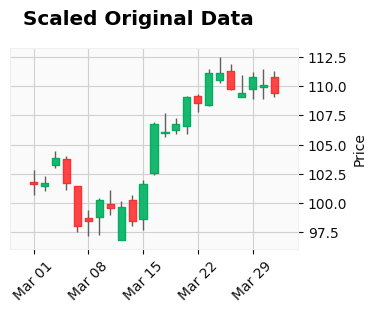

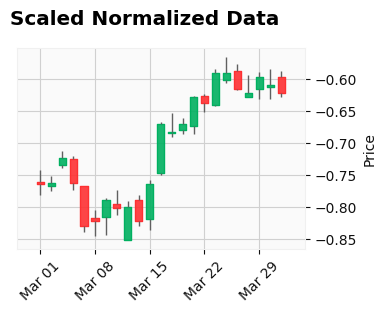

In [6]:
# view both datasets as candle-stick charts, lets say one month each
import matplotlib.pyplot as plt
import mplfinance as mpf

FIG_SCALE = 0.5

plot_data_org = data.loc['2000-03-01':'2000-03-31']
plot_data_nor = scaled_train_df.loc['2000-03-01':'2000-03-31']

mpf.plot(plot_data_org, type='candle', volume=False, title='Scaled Original Data', style='yahoo', figscale=FIG_SCALE)
mpf.plot(plot_data_nor, type='candle', volume=False, title='Scaled Normalized Data', style='yahoo', figscale=FIG_SCALE)

# PPO training and evaluation code
Now its time to get the data and train the model

In [ ]:
from supporting_classes import TradingEnv
from stable_baselines3 import PPO

# Create environment
env = TradingEnv(scaled_train_df, window_size=50)


# Define PPO model with tuned hyperparameters for trading
model = PPO(
    "MlpPolicy",                # Use a Multi-Layer Perceptron policy
    env,                        # Pass the trading environment
    learning_rate=0.0003,       # Lower learning rate for more stable updates
    n_steps=4096,               # Number of steps per rollout (larger for stability)
    batch_size=256,             # Batch size for gradient updates
    n_epochs=10,                # Number of epochs per update
    gamma=0.99,                 # Discount factor (shorter horizon for trading)
    gae_lambda=0.95,            # GAE parameter for advantage estimation
    clip_range=0.2,             # PPO clipping range
    ent_coef=0.05,              # Encourage exploration
    vf_coef=0.5,                # Weight for value function loss
    max_grad_norm=0.5,          # Gradient clipping for stability
    normalize_advantage=True,   # Helps with stability
    policy_kwargs=dict(net_arch=[256, 256]),  # Larger network for complex patterns
    verbose=1                   # Print training logs
)

model.learn(total_timesteps=100_000)        # train the model for 100,000 timesteps

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1732 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 4096 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.18e+03    |
|    ep_rew_mean          | 554         |
| time/                   |             |
|    fps                  | 1382        |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009148865 |
|    clip_fraction        | 0.0798      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.0126      |
|    learning_rate        | 0.0003      |
|    loss               

# Save the model

In [ ]:
# craete a file name depending on the last trained date
filenPath = f"../models/ppo_trading_{scaled_train_df.index[split_idx - 1].strftime('%Y_%m_%d')}"

print(scaled_train_df.tail()  )

# save the trained model
print(f"Saving model as {filenPath}")
model.save(filenPath)         

# Initial Testing
Now let's test the mode

In [ ]:
# Test-Umgebung erstellen
test_env = TradingEnv(scaled_test_df, window_size=50)

# Evaluation
obs, info = test_env.reset()                    # reset the environment to start a new episode
total_reward = 0                                # initialize total reward
steps = 0                                       # initialize step counter

while True:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = test_env.step(action)
    total_reward += reward
    steps += 1
    if done:
        break

print(f"Total Reward on Test Data: {total_reward:.4f}")
print(f"Steps: {steps}")
